<font size="5">Deep spectral learning for label-free optical imaging oximetry with uncertainty quantification</font>

<font size="4">Paper on bioAxiv: doi: https://doi.org/10.1101/650259</font>

<font size="4">Authors: Rongrong Liu, Shiyi Cheng, Lei Tian, Ji Yi</font>

<font size="5">Import libraries:</font>

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from IPython.display import clear_output
from keras.wrappers.scikit_learn import KerasRegressor
import keras
import numpy
import matplotlib.pyplot as plt
import random
import keras.backend as K
seed = 7
numpy.random.seed(seed)
import os
from keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy, scipy.io
from IPython.display import Image

Using TensorFlow backend.


<font size="5">Data Visualization for train and test sets:</font>

Size of training data:  (3130, 28)
Maximum and minimum of training data: 0.99 0.44
Size of testing data:  (502, 28)
Maximum and minimum of testing data: 0.98 0.6


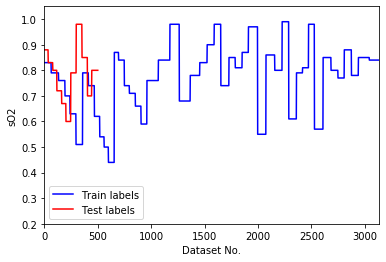

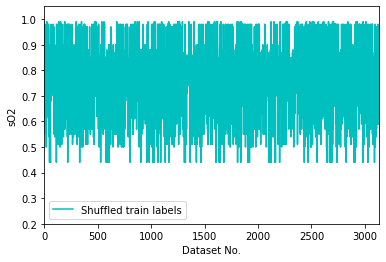

In [4]:
# load in dataset

dataset1=numpy.loadtxt('data_train_rolling_avg_whole_pixels_100_random5_Light_revised_shuffled_LSF2.csv',delimiter=',')
datasett10=numpy.loadtxt('data_test_rolling_avg_whole_pixels_100_4Lsn_Light_revised_shuffled_LSF2.csv',delimiter=',')
datasett20=numpy.loadtxt('data_test_rolling_avg_whole_pixels_SYC_100_3Bsn_Light_revised_shuffled_LSF2.csv',delimiter=',')

#===================================================================================================
# training data:
dataset=numpy.concatenate((datasett10,dataset1[248:544,:],dataset1[544:849,:],
                           datasett20,dataset1[849:1181,:],dataset1[1181:1468,:],
                                      dataset1[1468:1810,:],dataset1[1810:2141,:],dataset1[2141:2525,:],
                          ))

# split train data into input(x) and output (y) variables
X=dataset[:,0:28]
Y=dataset[:,42]
temp = [i for i in range(X.shape[0])]
random.shuffle(temp)
X_train = numpy.array([X[i] for i in temp])
Y_train = numpy.array([Y[i] for i in temp])
max_v = max(Y)
min_v = min(Y)
mean_v = numpy.mean(Y)
print('Size of training data: ', X_train.shape)
print("Maximum and minimum of training data:", max_v,min_v)


#===================================================================================================
# testing data:
datasett1=dataset1[0:248,:]
datasett2=dataset1[2525:2779,:]
datasett=numpy.concatenate((datasett1,datasett2))

# split test data into input(x) and output (y) variables
Xt=datasett[:,0:28]  # concatenated spectra
Yt=datasett[:,42]  # labels
Yf=datasett[:,43]  # LSF results
#scipy.io.savemat('test_so2_label.mat', mdict={'Yt': Yt})  # save LSF results for test data
print('Size of testing data: ', Xt.shape)
print("Maximum and minimum of testing data:", max(Yt),min(Yt))


#===================================================================================================
# plot the data

x=numpy.linspace(1,len(Y),len(Y))
plt.plot(x,Y,'b',label='Train labels')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,3130.0,0.2,1.05])

x=numpy.linspace(1,len(Yt),len(Yt))
plt.plot(x,Yt,'r',label='Test labels')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
#plt.axis([0.0,502.0,0.4,1.05])
plt.show()

x=numpy.linspace(1,len(Y_train),len(Y_train))
plt.plot(x,Y_train,'c',label='Shuffled train labels')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,3130.0,0.2,1.05])
plt.show()


  <font size="5">Define plot funtion:</font>  

In [5]:
# define plot:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


 <font size="5">Define customized Gaussian loss function:</font>

In [6]:
# define customized loss function:
def Gaussian_loss(y_true, y_pred):
    mean_true = y_true[:,0]
    mean_pred = y_pred[:,0]
    scale_pred = y_pred[:,1]
    loss = K.tf.divide(K.square(mean_true - mean_pred), scale_pred + 1e-8) + K.log(scale_pred + 1e-8)
    return loss

  <font size="5">Train FNN model:</font>  

In [8]:
# Creat FNN model with uncertainty
model_nn1c = Sequential()
model_nn1c.add(Dense(24,input_dim=28,kernel_initializer='normal',activation='relu'))
model_nn1c.add(Dense(24,kernel_initializer='normal',activation='relu'))
model_nn1c.add(Dense(2,kernel_initializer='normal',activation='sigmoid'))
sgd = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-30, decay=0.01,amsgrad=False)
model_nn1c.compile(loss=Gaussian_loss, optimizer='sgd')

num_iters=2000
proj_name='NN_uncertainty_avg_100c_9'
val_lossNNu3=1e7

lr_G0=2.5e-3
decy=0.01

os.remove('log1_' + proj_name + '.txt')
os.remove('log2_' + proj_name + '.txt')
os.remove('log3_' + proj_name + '.txt')
os.remove('log4_' + proj_name + '.txt')

X1 = numpy.expand_dims(X_train, axis=2) # reshape (569, 30, 1) 
print(X1.shape)
Xtt = numpy.expand_dims(Xt, axis=2) # reshape (569, 30, 1) 

for iteration in range(0, num_iters, 1):
    #if iteration in [1000,5000,10000,15000,20000,25000]:
    print(iteration+1)
    lr_G=numpy.divide(lr_G0,(1+numpy.multiply(iteration+1,decy)))
    #print(lr_G)
    K.set_value(model_nn1c.optimizer.lr, lr_G)    


    history=model_nn1c.fit(X_train, Y_train, validation_split=0.2,epochs=1,batch_size=50, verbose=0,shuffle=False)
    preds = model_nn1c.predict(Xt)
    
    tmp=str(history.history['val_loss'])
    tmp=float(tmp[2:-1])
    tmp=numpy.multiply(tmp,-1)
    
    if tmp < val_lossNNu3:
        val_lossNNu3=tmp
        model_nn1c.save('Model_NN_uncertainty_100c_9.h5')
    
    rounds = [x[0] for x in preds]
    rounds_val = [x[1] for x in preds]
    rounds_std=numpy.sqrt(rounds_val)
    
    txt_file = open('log2_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' std: ' +
                   str(rounds_std) + '\n')
    txt_file.close()
    
    txt_file = open('log1_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' sO2: ' +
                   str(rounds) + '\n')
    txt_file.close()
    
    txt_file = open('log3_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' loss: ' +
                   str(history.history['loss']) + '\n')
    txt_file.close()
    
    txt_file = open('log4_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' val_loss: ' +
                   str(history.history['val_loss']) + '\n')
    txt_file.close()

(3130, 28, 1)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


  <font size="5">Plot learning curve of FNN model:</font>  

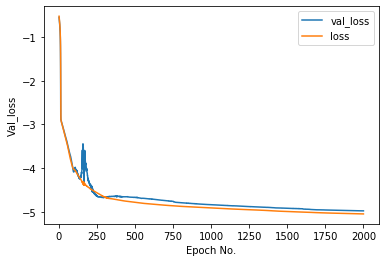

['val_loss: ', -4.980347438361317]


In [25]:
proj_name='NN_uncertainty_avg_100c_9'
with open('log4_' + proj_name + '.txt') as f:
    lines = f.readlines()
    x = [line.split()[1] for line in lines]
    y = [line.split()[3] for line in lines]
    f.close()

with open('log3_' + proj_name + '.txt') as f:
    lines = f.readlines()
    z = [line.split()[3] for line in lines]
    f.close() 
    
x = [float(i) for i in x]
y = [(i[2:-1]) for i in y]
y = [float(j) for j in y]
z = [(i[2:-1]) for i in z]
z = [float(j) for j in z]
    
plt.plot(x, numpy.multiply(-1,y),label='val_loss')
plt.plot(x,numpy.multiply(-1,z),label='loss')
plt.xlabel('Epoch No.')
plt.ylabel('Val_loss')
plt.legend()
plt.show()

tmp=min(numpy.multiply(-1,y))
print(['val_loss: ', tmp])
model_nn1c = load_model('Model_NN_uncertainty_100c_9.h5', custom_objects={'Gaussian_loss': Gaussian_loss})

In [27]:
# save FNN results for test data:

#test_so2=numpy.loadtxt('OCT_14_27_16_05V_spectraall_demo_for_python.csv',delimiter=',')
test_so2=numpy.loadtxt('OCT_14_48_16_05V_spectraall_demo_for_python_try.csv',delimiter=',')
#test_so2=numpy.loadtxt('OCT_14_53_00_05V_spectraall_demo_for_python.csv',delimiter=',')
test_so2.shape
Xt_so2=test_so2[:,0:28]
predictions=model_nn1c.predict(Xt_so2)

predictions_so2 = [x[0] for x in predictions]
predictions_so2_val = [x[1] for x in predictions]


#scipy.io.savemat('NN_uncertainty_map_so2_14_27_16_o2.mat', mdict={'predictions_so2': predictions_so2})
#scipy.io.savemat('NN_uncertainty_map_val_14_27_16_o2.mat', mdict={'predictions_so2_val': predictions_so2_val})

scipy.io.savemat('NN_uncertainty_map_so2_14_48_16_o2_try.mat', mdict={'predictions_so2': predictions_so2})
scipy.io.savemat('NN_uncertainty_map_val_14_48_16_o2_try.mat', mdict={'predictions_so2_val': predictions_so2_val})

#scipy.io.savemat('NN_uncertainty_map_so2_14_53_00_o2.mat', mdict={'predictions_so2': predictions_so2})
#scipy.io.savemat('NN_uncertainty_map_val_14_53_00_o2.mat', mdict={'predictions_so2_val': predictions_so2_val})

  <font size="5">Plot results prediced by FNN model:</font>  

['NN MSE with uncertainty: ', 0.0035384734643420374]


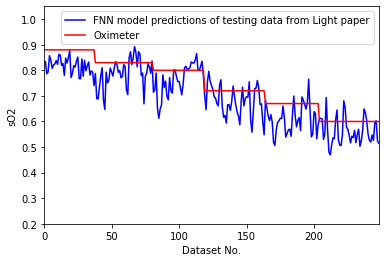

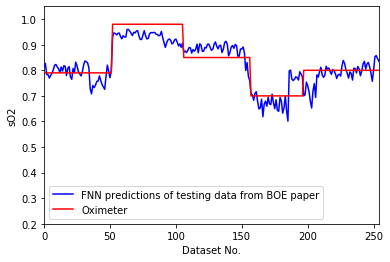

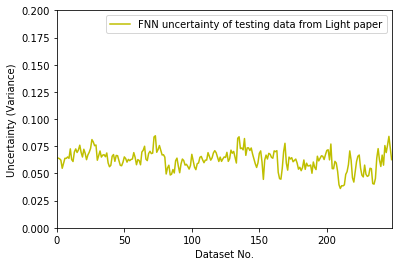

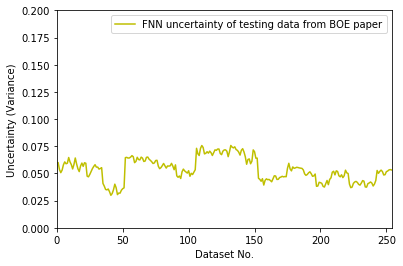

In [24]:
# plot FNN results:

predictions2c = model_nn1c.predict(Xt)
rounded2c = [x[0] for x in predictions2c]
rounded2_valc = [x[1] for x in predictions2c]
#print(numpy.add(rounded3_val,rounded3))

scores2c = (numpy.subtract(rounded2c,Yt)**2).mean()
print(['MSE of FNN model: ',scores2c])


# plot the data
x=numpy.linspace(1,len(rounded2c[:248]),len(rounded2c[:248]))
plt.plot(x,rounded2c[:248],'b',label='FNN model predictions of testing data from Light paper')
plt.plot(x,Yt[:248],'r',label='Oximeter')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,248.0,0.2,1.05])
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2c[248:]),len(rounded2c[248:]))
plt.plot(x,rounded2c[248:],'b',label='FNN predictions of testing data from BOE paper')
plt.plot(x,Yt[248:],'r',label='Oximeter')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,254.0,0.2,1.05])                 
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2_valc[:248]),len(rounded2_valc[:248]))
plt.plot(x,numpy.sqrt(rounded2_valc[:248]),'y',label='FNN uncertainty of testing data from Light paper')
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('Uncertainty (Variance)')
plt.axis([0.0,248.0,0,0.2])
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2_valc[248:]),len(rounded2_valc[248:]))
plt.plot(x,numpy.sqrt(rounded2_valc[248:]),'y',label='FNN uncertainty of testing data from BOE paper')
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('Uncertainty (Variance)')
plt.axis([0.0,254.0,0,0.2])               
plt.show()

In [14]:
# save FNN results:
scipy.io.savemat('NN_uncertainty_so2.mat', mdict={'rounded2d': rounded2c})
scipy.io.savemat('NN_uncertainty_val.mat', mdict={'rounded2_vald': rounded2_valc})

  <font size="5">Train CNN model:</font>  

In [48]:
# create CNN model with uncertainty

model_cnn1 = Sequential()
model_cnn1.add(Conv1D(30,3, activation='relu',input_shape = (28,1)))
model_cnn1.add(Conv1D(30,3,activation='relu'))
model_cnn1.add(Flatten())
model_cnn1.add(Dense(2, activation = 'sigmoid'))
print(model_cnn1.summary())
sgd = optimizers.Adam(lr=5e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=True)
model_cnn1.compile(loss=Gaussian_loss,optimizer='sgd')


num_iters=2000
proj_name='CNN_uncertainty_avg_100a_9'
val_lossCNNu1=1e7

lr_G0=2.5e-3
decy=0.01

os.remove('log1_' + proj_name + '.txt')
os.remove('log2_' + proj_name + '.txt')
os.remove('log3_' + proj_name + '.txt')
os.remove('log4_' + proj_name + '.txt')

X1 = numpy.expand_dims(X_train, axis=2) # reshape (569, 30, 1) 
print(X1.shape)
Xtt = numpy.expand_dims(Xt, axis=2) # reshape (569, 30, 1) 

for iteration in range(0, num_iters, 1):
    #if iteration in [1000,5000,10000,15000,20000,25000]:
    print(iteration+1)
    lr_G=numpy.divide(lr_G0,(1+numpy.multiply(iteration+1,decy)))
    #print(lr_G)
    K.set_value(model_cnn1.optimizer.lr, lr_G)   


    history=model_cnn1.fit(X1, Y_train, validation_split=0.2,epochs=1,batch_size=50, verbose=0,shuffle=False)
    preds = model_cnn1.predict(Xtt)
    
    tmp=str(history.history['val_loss'])
    tmp=float(tmp[2:-1])
    tmp=numpy.multiply(tmp,-1)
    
    if tmp < val_lossCNNu1:
        val_lossCNNu1=tmp
        model_cnn1.save('Model_CNN_uncertainty_100a_9.h5')
    
    rounds = [x[0] for x in preds]
    rounds_val = [x[1] for x in preds]
    rounds_std=numpy.sqrt(rounds_val)
    
    txt_file = open('log2_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' std: ' +str(rounds_std) + '\n')
    txt_file.close()
    
    txt_file = open('log1_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' sO2: ' +str(rounds) + '\n')
    txt_file.close()
    
    txt_file = open('log3_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' loss: ' +str(history.history['loss']) + '\n')
    txt_file.close()
    
    txt_file = open('log4_' + proj_name + '.txt', "a")
    txt_file.write('Iter: ' + str(iteration + 1) + ' val_loss: ' +str(history.history['val_loss']) + '\n')
    txt_file.close()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 26, 30)            120       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 30)            2730      
_________________________________________________________________
flatten_4 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 1442      
Total params: 4,292
Trainable params: 4,292
Non-trainable params: 0
_________________________________________________________________
None
(3130, 28, 1)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
8

1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885


  <font size="5">Plot learning curve of CNN model:</font>  

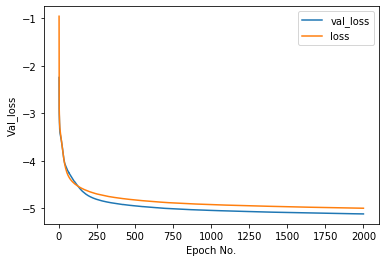

['val_loss: ', -5.114801126547134]


In [26]:
# plot learning curve:
Xtt = numpy.expand_dims(Xt, axis=2) # reshape (569, 30, 1) 
proj_name='CNN_uncertainty_avg_100a_9' # use this for statistical analysis
with open('log4_' + proj_name + '.txt') as f:
    lines = f.readlines()
    x = [line.split()[1] for line in lines]
    y = [line.split()[3] for line in lines]
    f.close()

with open('log3_' + proj_name + '.txt') as f:
    lines = f.readlines()
    z = [line.split()[3] for line in lines]
    f.close() 
    
x = [float(i) for i in x]
y = [(i[2:-1]) for i in y]
y = [float(j) for j in y]
z = [(i[2:-1]) for i in z]
z = [float(j) for j in z]
    
plt.plot(x, numpy.multiply(-1,y),label='val_loss')
plt.plot(x,numpy.multiply(-1,z),label='loss')
plt.xlabel('Epoch No.')
plt.ylabel('Val_loss')
plt.legend()
plt.show()

tmp=min(numpy.multiply(-1,y))
print(['val_loss: ', tmp])


model_Cnn1 = load_model('Model_CNN_uncertainty_100a_9.h5', custom_objects={'Gaussian_loss': Gaussian_loss})

  <font size="5">Plot results prediced by CNN model:</font>  

['MSE of CNN model: ', 0.003199538241220205]


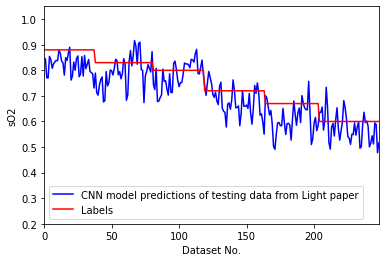

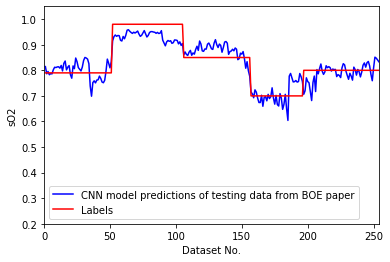

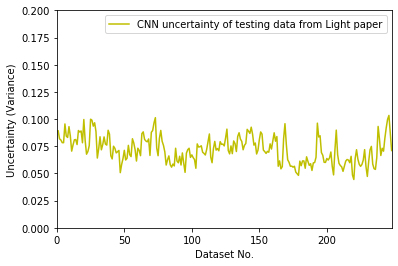

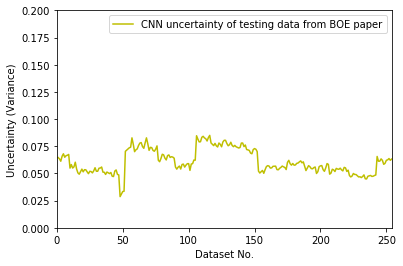

In [22]:
# plot CNN results:

predictions2b = model_Cnn1.predict(Xtt)
# round predictions
rounded2b = [x[0] for x in predictions2b]
rounded2_valb = [x[1] for x in predictions2b]
#print(numpy.add(rounded3_val,rounded3))

scores2b = (numpy.subtract(rounded2b,Yt)**2).mean()
print(['MSE of CNN model: ',scores2b])

# plot the data
x=numpy.linspace(1,len(rounded2b[:248]),len(rounded2b[:248]))
plt.plot(x,rounded2b[:248],'b',label='CNN model predictions of testing data from Light paper')
plt.plot(x,Yt[:248],'r',label='Labels')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,248.0,0.2,1.05])
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2b[248:]),len(rounded2b[248:]))
plt.plot(x,rounded2b[248:],'b',label='CNN model predictions of testing data from BOE paper')
plt.plot(x,Yt[248:],'r',label='Labels')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,254.0,0.2,1.05])                 
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2_valb[:248]),len(rounded2_valb[:248]))
plt.plot(x,numpy.sqrt(rounded2_valb[:248]),'y',label='CNN uncertainty of testing data from Light paper')
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('Uncertainty (Variance)')
plt.axis([0.0,248.0,0,0.2])
plt.show()

# plot the data
x=numpy.linspace(1,len(rounded2_valb[248:]),len(rounded2_valb[248:]))
plt.plot(x,numpy.sqrt(rounded2_valb[248:]),'y',label='CNN uncertainty of testing data from BOE paper')
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('Uncertainty (Variance)')
plt.axis([0.0,254.0,0,0.2])               
plt.show()

In [19]:
# save CNN results:
scipy.io.savemat('CNN_uncertainty_so2.mat', mdict={'rounded2b': rounded2b})
scipy.io.savemat('CNN_uncertainty_val.mat', mdict={'rounded2_valb': rounded2_valb})

In [29]:
## save predicted results for test data:

#test_so2=numpy.loadtxt('OCT_14_27_16_05V_spectraall_demo_for_python.csv',delimiter=',')
test_so2=numpy.loadtxt('OCT_14_48_16_05V_spectraall_demo_for_python.csv',delimiter=',')
#test_so2=numpy.loadtxt('OCT_14_53_00_05V_spectraall_demo_for_python.csv',delimiter=',')

test_so2.shape
Xt_so2=test_so2[:,0:28]
Xtt_so2 = numpy.expand_dims(Xt_so2, axis=2) # reshape (569, 30, 1) 
predictions=model_Cnn1.predict(Xtt_so2)

predictions_so2 = [x[0] for x in predictions]
predictions_so2_val = [x[1] for x in predictions]

#scipy.io.savemat('CNN_uncertainty_map_so2_14_27_16_o2.mat', mdict={'predictions_so2': predictions_so2})
#scipy.io.savemat('CNN_uncertainty_map_val_14_27_16_o2.mat', mdict={'predictions_so2_val': predictions_so2_val})

scipy.io.savemat('CNN_uncertainty_map_so2_14_48_16_o2.mat', mdict={'predictions_so2': predictions_so2})
scipy.io.savemat('CNN_uncertainty_map_val_14_48_16_o2.mat', mdict={'predictions_so2_val': predictions_so2_val})

#scipy.io.savemat('CNN_uncertainty_map_so2_14_53_00_o2.mat', mdict={'predictions_so2': predictions_so2})
#scipy.io.savemat('CNN_uncertainty_map_val_14_53_00_o2.mat', mdict={'predictions_so2_val': predictions_so2_val})

  <font size="5">Plot results prediced by traditional least-square fitting (LSF) method:</font>  

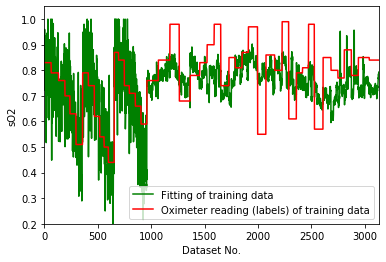

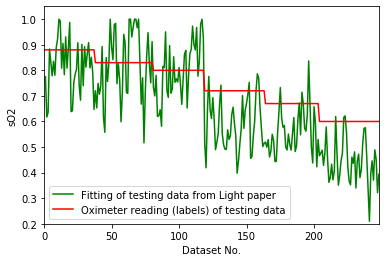

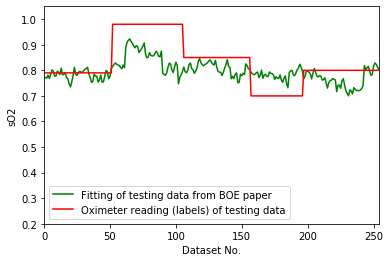

['MSE of fitting the testing data from Light paper: ', 0.020783027610483867]
['MSE of fitting the testing data from BOE paper: ', 0.006555328387795276]
['MSE of fitting the testing data from both Light and BOE papers: ', 0.013584151908167329]


In [14]:
# plot LSF results for train and test data:

data=numpy.loadtxt('data_all_LSF_optimization.csv',delimiter=',')


# results of training data:
dataset=numpy.concatenate((data[2779:3138],data[248:544,:],data[544:849,:],
                           data[3138:],data[849:1181,:],data[1181:1468,:],
                                      data[1468:1810,:],data[1810:2141,:],data[2141:2525,:],
                          ))


Yh1=dataset[:,43]
Yh2=dataset[:,42]
x=numpy.linspace(1,len(Yh1),len(Yh1))
plt.plot(x,Yh1,'g',label='Fitting of training data')
#plt.plot(x, rounded2,'b',label='NN Predictions')
#plt.plot(x, rounded1,'black',label='1D CNN Predictions')
plt.plot(x,Yh2,'r',label='Oximeter reading (labels) of training data')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,3130.0,0.2,1.05])
plt.show()


# results of testing data:
datasett1=data[0:248,:]
datasett2=data[2525:2779,:]
datasett=numpy.concatenate((datasett1,datasett2))
Yt=datasett[:,42]
Yf=datasett[:,43]

x=numpy.linspace(1,len(Yt[:248]),len(Yt[:248]))
plt.plot(x,Yf[:248],'g',label='Fitting of testing data from Light paper')
#plt.plot(x, rounded2,'b',label='NN Predictions')
#plt.plot(x, rounded1,'black',label='1D CNN Predictions')
plt.plot(x,Yt[:248],'r',label='Oximeter reading (labels) of testing data')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,248.0,0.2,1.05])
plt.show()

x=numpy.linspace(1,len(Yt[248:]),len(Yt[248:]))
plt.plot(x,Yf[248:],'g',label='Fitting of testing data from BOE paper')
#plt.plot(x, rounded2,'b',label='NN Predictions')
#plt.plot(x, rounded1,'black',label='1D CNN Predictions')
plt.plot(x,Yt[248:],'r',label='Oximeter reading (labels) of testing data')
# Add a legend
plt.legend()
plt.xlabel('Dataset No.')
plt.ylabel('sO2')
plt.axis([0.0,254.0,0.2,1.05])
plt.show()

scipy.io.savemat('least_square_test_so2.mat', mdict={'Yf': Yf})


scoresf1 = (numpy.subtract(Yf[:248],Yt[:248])**2).mean()
print(['MSE of fitting the testing data from Light paper: ',scoresf1])

scoresf2 = (numpy.subtract(Yf[248:],Yt[248:])**2).mean()
print(['MSE of fitting the testing data from BOE paper: ',scoresf2])

scoresf = (numpy.subtract(Yf,Yt)**2).mean()
print(['MSE of fitting the testing data from both Light and BOE papers: ',scoresf])

